# Model training
### In this notebook we train one model for each cluster with the following characteristics:
* Less features (no prev_val features)
* Smaller model with less layers

# Imports

In [1]:
import os
import random
import calendar
import datetime
import warnings
import logging
import numpy as np
import pandas as pd
from datetime import timedelta
from collections import Counter
from google.cloud import bigquery

from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets

warnings.filterwarnings("ignore")
tqdm.pandas()

In [2]:
import comet_ml
from comet_ml import Experiment, Optimizer
logging.getLogger("comet_ml").setLevel("ERROR")

import scipy.stats
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel("ERROR")

from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm.keras import TqdmCallback

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Config

In [3]:
# Config
PROJECT_ID = "arpae-prod-ml"

# BigQuery
# JOINED_BQ_DATASET = "JOINED_DATA"
# JOINED_DATA_TABLE = "ALL_METEO_FEATS_POL_DAT"

# Dataset path
dataset_path = "data/"

# Ouput
model_output = "models"

## Methods

In [4]:
def _run_query(client, query):
    df = client.query(query).to_dataframe()
    return df

def _create_station_widget(df):
    station_ids = df.station_id.sort_values().unique()
    station_wdgt = widgets.Dropdown(options=station_ids, description='Station Id:', layout={"width":"50%"})
    return station_wdgt

def _create_pol_var_id_widget(df):
    pol_var_ids = df.pol_var_id.sort_values().unique()
    pol_wdgt = widgets.Dropdown(options=pol_var_ids, description='Pol var id:', layout={"width":"50%"})
    return pol_wdgt

def _create_cluster_n_widget(df):
    cluster_ids = list(df.cluster.sort_values().unique())
    cluster_ids.append("all")
    cls_wdgt = widgets.Dropdown(options=cluster_ids, description='Cluster id:', layout={"width":"50%"})
    return cls_wdgt

def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

# 1. Load Dataset

### Load clustering results

In [5]:
### Load clustering data
# clusters = pd.read_csv("../data/clusters/clustering_tsd_intervals.csv")
clusters = pd.read_csv("data/clusters/clustering_intervals.csv")

print(clusters.shape)
display(clusters.sample(3))

# plt.figure(figsize=(8,2))
# plt.title("Number of specie/station per cluster")
# sns.countplot(x=clusters["cluster"]);

(363, 3)


,station_id,pol_var_id,cluster
109,5,B48015,9
239,9,B48012,4
261,9,B48041,3


### Load dataset

In [6]:
window_size = 7
dataset_path, dataset_type = f"data/dataset_7D_normalized_tsd-signature.feather", "normalized"

# Load dataset
df_dataset = pd.read_feather(dataset_path)
df_dataset.drop_duplicates(inplace=True)

# Convert dates, sort and set index
df_dataset.date = pd.to_datetime(df_dataset.date)
df_dataset.sort_values(["station_id", "pol_var_id", "date"], inplace=True)
df_dataset.set_index("date", inplace=True)

In [7]:
# Select species/stations from cluster result
df_dataset.station_id = df_dataset.station_id.astype(int)
df_dataset.dropna(inplace=True)

In [8]:
### Dataset preview
print(df_dataset.shape)
df_dataset.head(5)

(1135172, 104)


,station_id,pol_var_id,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,B14198_max_amax,B14198_mean_mean,...,pol_var_id_B48041,pol_var_id_B48044,pol_var_id_B48045,WHICH,day,month,year,cluster,season_signature,trend_signature
date,,,,,,,,,,,,,,,,,,,,,
2006-09-05,1,B48001,0.0,0.010309,0.007163,0.010346,0.005140,0.555556,0.707631,0.648377,...,0,0,0,training,5,9,2006,3,0.152378,0.591799
2006-09-06,1,B48001,0.0,0.010309,0.001791,0.004397,0.001285,0.555556,0.707631,0.644707,...,0,0,0,training,6,9,2006,3,0.096312,0.594864
2006-09-07,1,B48001,0.0,0.000000,0.000000,0.000000,0.000000,0.555556,0.684836,0.625042,...,0,0,0,training,7,9,2006,3,0.125102,0.597809
2006-09-08,1,B48001,0.0,0.017182,0.015519,0.011157,0.011137,0.555556,0.677899,0.585648,...,0,0,0,training,8,9,2006,3,0.132521,0.600025
2006-09-09,1,B48001,0.0,0.044674,0.031038,0.037994,0.022275,0.555556,0.679881,0.582157,...,0,0,0,training,9,9,2006,3,0.128263,0.602592


# 2. Define training parameters

In [9]:
all_features = sorted(set([
    # 'station_id', 'pol_var_id', 'pol_value_label',
    # 'season_label', 'seasonal_mean', 'seasonal_prev_1',
    # 'trend_label', 'trend_mean', 'trend_prev_1',
    # 'residual_label', 'residual_mean', 'residual_prev_1',
    # 'week_amax',
    'B13011_mean_mean', 'B13011_min_amin', 'B13011_max_amax', 'B13011_std_mean', 'B13011_sum_sum',
    'B14198_mean_mean', 'B14198_min_amin', 'B14198_max_amax', 'B14198_std_mean', 'B14198_sum_sum',
    'TEMP_mean_mean', 'TEMP_min_amin', 'TEMP_max_amax', 'TEMP_std_mean', 'TEMP_sum_sum',
    'station_lat_amax', 'station_lon_amax',
    'station_H_piano_strada_amax', 'station_H_mslm_amax',
    'PREC_mean', 'PREC_amin', 'PREC_amax', 'PREC_median', 'PREC_std', 'PREC_skew', 'PREC_kurtosis',
    'pol_value_amin', 'pol_value_mean', 'pol_value_amax', 'pol_value_std', 'pol_value_median', 'pol_value_skew', 'pol_value_kurtosis',
    'pol_value_prev_1', 'pol_value_prev_2', 'pol_value_prev_3', 'pol_value_prev_4', 'pol_value_prev_5', 'pol_value_prev_6', 'pol_value_prev_7',
    'station_id_1', 'station_id_2', 'station_id_4', 'station_id_5', 'station_id_6', 'station_id_7', 'station_id_8', 'station_id_9', 'station_id_10', 'station_id_11', 'station_id_13',
    'pol_var_id_B48001', 'pol_var_id_B48002', 'pol_var_id_B48003', 'pol_var_id_B48005', 'pol_var_id_B48006', 'pol_var_id_B48007', 'pol_var_id_B48008', 'pol_var_id_B48011', 'pol_var_id_B48012', 'pol_var_id_B48013', 'pol_var_id_B48015', 'pol_var_id_B48016', 'pol_var_id_B48017', 'pol_var_id_B48018', 'pol_var_id_B48019', 'pol_var_id_B48021', 'pol_var_id_B48023', 'pol_var_id_B48024', 'pol_var_id_B48025', 'pol_var_id_B48026', 'pol_var_id_B48029', 'pol_var_id_B48030', 'pol_var_id_B48031', 'pol_var_id_B48032', 'pol_var_id_B48033', 'pol_var_id_B48034', 'pol_var_id_B48036', 'pol_var_id_B48037', 'pol_var_id_B48038', 'pol_var_id_B48039', 'pol_var_id_B48041', 'pol_var_id_B48044', 'pol_var_id_B48045',
    'season_signature', 'trend_signature'
]))

y_label = "pol_value_label"

print(f"Len features: {len(all_features)}")
print(f"y_label: {y_label}")

Len features: 86
y_label: pol_value_label


In [10]:
def get_dataset(cluster_n, params):
    # Create an object to store dataset and results
    class dataset: pass

    if cluster_n != "all":
        dataset.cluster_n = cluster_n
        df_feature = df_dataset[df_dataset.cluster == cluster_n].copy()
    else:
        dataset.cluster_n = cluster_n
        df_feature = df_dataset.copy()
    
    # Create cluster training/test/validation split
    dataset.x_train = df_feature[df_feature.WHICH == "training"]
    dataset.y_train = df_feature[df_feature.WHICH == "training"][[y_label]]
    dataset.x_valid = df_feature[df_feature.WHICH == "validation"]
    dataset.y_valid = df_feature[df_feature.WHICH == "validation"][[y_label]]
    dataset.x_test = df_feature[df_feature.WHICH == "test"]
    dataset.y_test = df_feature[df_feature.WHICH == "test"][[y_label]]
    
    # Drop all-0 columns (one hot encodings)
    to_keep = [c for c in dataset.x_train.columns if dataset.x_train[c].any()]
    dataset.features = [feature for feature in all_features if feature in to_keep]

    # Create timeseries dataset
    dataset.train_dataset = timeseries_dataset_from_array(dataset.x_train[dataset.features], dataset.y_train, sequence_length=params.sequence_length, batch_size=params.batch_size)
    dataset.valid_dataset = timeseries_dataset_from_array(dataset.x_valid[dataset.features], dataset.y_valid, sequence_length=params.sequence_length, batch_size=params.batch_size)
    dataset.test_dataset = timeseries_dataset_from_array(dataset.x_test[dataset.features], dataset.y_test, sequence_length=params.sequence_length, batch_size=params.batch_size)

    return dataset

___

# 3. Model structure definition
* Attention+AdamW

In [11]:
model_arch_name = "Attention+AdamW_TSD-sign"

# def get_model(params, feature_len):
#     # Define model inputs
#     input_layer = tf.keras.layers.Input(shape=(params.sequence_length, feature_len))

#     ### Attention layer
#     attn_layer = tf.keras.layers.Mu()([input_layer, input_layer])
#     attn_output = tf.keras.layers.Dense(units=params.dense_1_units)(attn_layer)

#     # Reshape attention layer
#     att_reshape = tf.keras.layers.Flatten()(attn_output)

#     # Dense layer
#     dense_lst_1 = tf.keras.layers.Dense(units=params.dense_1_units)(att_reshape)
#     dropout_1 = tf.keras.layers.Dropout(params.dropout)(dense_lst_1)
#     dense_lst_2 = tf.keras.layers.Dense(units=params.dense_2_units)(dropout_1)

#     # Output layer
#     output_layer = tf.keras.layers.Dense(units=1)(dense_lst_2)

#     # Define model architecture
#     model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

#     # Optimizer
#     optimizer = AdamW(learning_rate=params.learning_rate)
#     model.compile(optimizer=optimizer, loss="mse")
#     return model

def get_model(params, feature_len):
    # Define model inputs
    input_layer = tf.keras.layers.Input(shape=(params.sequence_length, feature_len))

    # LSTM Layer
    lstm_1 = tf.keras.layers.LSTM(units=params.lstm_1_units, dropout=params.dropout, return_sequences=True)(input_layer)
    lstm_2 = tf.keras.layers.LSTM(units=params.lstm_2_units, dropout=params.dropout, return_sequences=True)(lstm_1)

    ### Multi head attention
    attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=lstm_2, value=lstm_2, key=lstm_2)
    attn_output = tf.keras.layers.Dense(units=params.dense_1_units)(attn_layer)

    # Reshape attention layer
    att_reshape = tf.keras.layers.Flatten()(attn_output)

    # Dense layer
    dense_lst_1 = tf.keras.layers.Dense(units=params.dense_1_units)(att_reshape)
    dropout_1 = tf.keras.layers.Dropout(params.dropout)(dense_lst_1)
    dense_lst_2 = tf.keras.layers.Dense(units=params.dense_2_units)(dropout_1)

    # Output layer
    output_layer = tf.keras.layers.Dense(units=1)(dense_lst_2)

    # Define model architecture
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Optimizer
    optimizer = AdamW(learning_rate=params.learning_rate)
    model.compile(optimizer=optimizer, loss="mse")
    return model

In [12]:
def train_model(dataset, params):
    model_name = f"{model_arch_name}_Cluster-{dataset.cluster_n}"
    print(f"Training model {model_name}")

    # Load model and fit dataset
    model = get_model(params=params, feature_len=len(dataset.features))

    history = model.fit(
        dataset.train_dataset,
        validation_data=dataset.valid_dataset,
        epochs=params.n_epochs,
        shuffle=params.shuffle,
        verbose=0,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=params.patience, verbose=1, mode="min", restore_best_weights=True),
            ModelCheckpoint(f"{model_output}/{model_name}.h5", monitor="val_loss", mode="min", save_best_only=True),
            TqdmCallback(verbose=1),
        ],
    )

    return history, model

___

# 4. Training

In [13]:
### Choose clusters for training and test
all_clusters = sorted(clusters.cluster.unique())

# for debugging purpose
# all_clusters = random.sample(all_clusters, 1)
# all_clusters = ["all"]

print(f"Training on clusters: {all_clusters}")

Training on clusters: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [16]:
# Model parameters
class model_params:
    lstm_1_units = 128
    lstm_2_units = 64
    dense_1_units = 64
    dense_2_units = 16
    dropout = .2
    learning_rate = 0.001
    batch_size = 1024
    sequence_length = 7
    n_epochs = 100
    patience = 10
    shuffle = True

In [17]:
trainings = []
for cluster_n in tqdm(all_clusters):
    # Load dataset
    dataset = get_dataset(cluster_n=cluster_n, params=model_params)

    # Fit model on dataset, store results
    dataset.history, dataset.model = train_model(dataset, model_params)
    trainings.append(dataset)

  0%|          | 0/10 [00:00<?, ?it/s]

Training model Attention+AdamW_TSD-sign_Cluster-0


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 83.
Epoch 93: early stopping
Training model Attention+AdamW_TSD-sign_Cluster-1


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 46.
Epoch 56: early stopping
Training model Attention+AdamW_TSD-sign_Cluster-2


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 40.
Epoch 50: early stopping
Training model Attention+AdamW_TSD-sign_Cluster-3


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 15.
Epoch 25: early stopping
Training model Attention+AdamW_TSD-sign_Cluster-4


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 66.
Epoch 76: early stopping
Training model Attention+AdamW_TSD-sign_Cluster-5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 66.
Epoch 76: early stopping
Training model Attention+AdamW_TSD-sign_Cluster-6


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 31.
Epoch 41: early stopping
Training model Attention+AdamW_TSD-sign_Cluster-7


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 16.
Epoch 26: early stopping
Training model Attention+AdamW_TSD-sign_Cluster-8


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 33.
Epoch 43: early stopping
Training model Attention+AdamW_TSD-sign_Cluster-9


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 30.
Epoch 40: early stopping


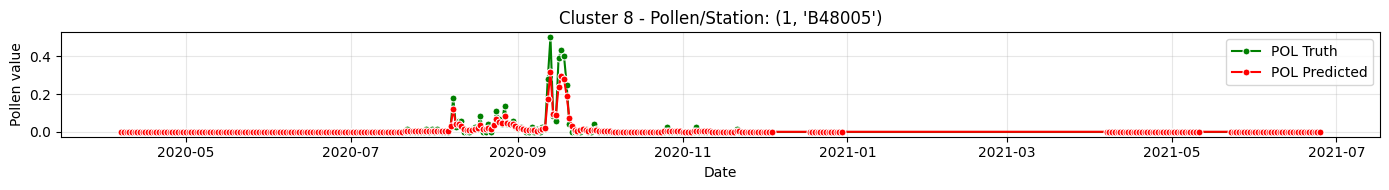

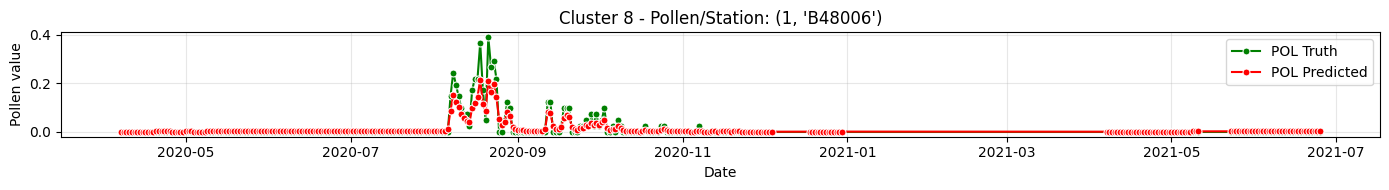

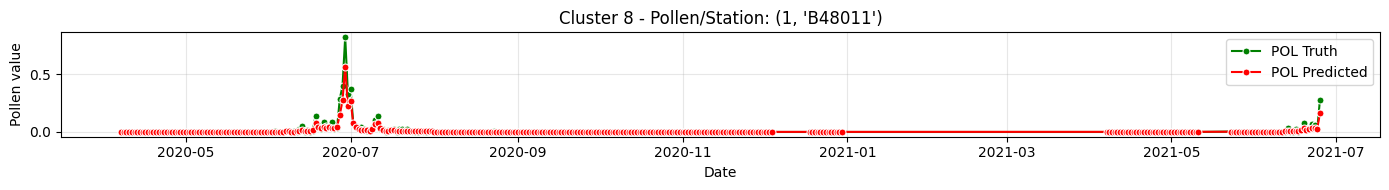

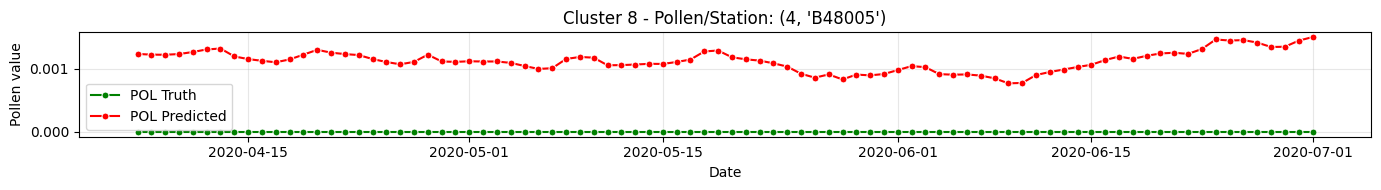

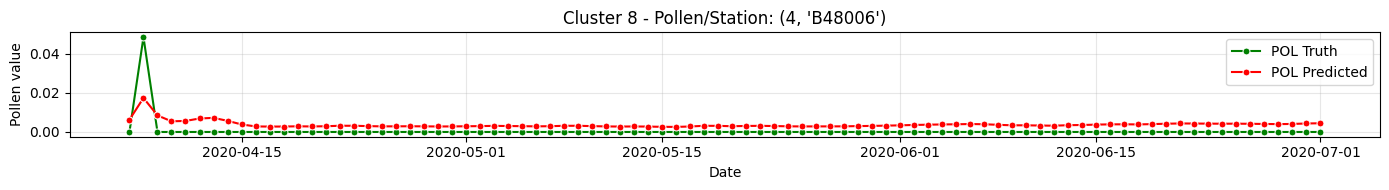

In [27]:
### Cluster specie/pollen prediction
specie_pollen_dataset = random.choice(trainings) #list(filter(lambda d: d.cluster_n == cluster_wgt.value, trainings))[0]

for plotn, (group_idx, specie_group) in enumerate(specie_pollen_dataset.x_test.groupby(["station_id", "pol_var_id"])):
    if plotn >= 5: break
    species_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(specie_group[specie_pollen_dataset.features], targets=None, sequence_length=model_params.sequence_length, batch_size=model_params.batch_size)
    specie_group = specie_group[:-model_params.sequence_length+1]
    predictions = specie_pollen_dataset.model.predict(species_dataset, verbose=False).squeeze()
    mse = specie_pollen_dataset.model.evaluate(species_dataset, verbose=False)

    plt.figure(figsize=(14, 2))
    plt.title(f"Cluster {specie_pollen_dataset.cluster_n} - Pollen/Station: {group_idx}")
    sns.lineplot(x=specie_group.index, y=specie_group.pol_value_label, marker="o", markersize=5, label="POL Truth", c="green")
    sns.lineplot(x=specie_group.index, y=predictions, marker="o", markersize=5, label="POL Predicted", c="red")
    plt.xlabel("Date")
    plt.ylabel("Pollen value")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [19]:
dataset.model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 7, 66)]      0           []                               
                                                                                                  
 lstm_18 (LSTM)                 (None, 7, 128)       99840       ['input_11[0][0]']               
                                                                                                  
 lstm_19 (LSTM)                 (None, 7, 64)        49408       ['lstm_18[0][0]']                
                                                                                                  
 multi_head_attention_9 (MultiH  (None, 7, 64)       132672      ['lstm_19[0][0]',                
 eadAttention)                                                    'lstm_19[0][0]',          

## 4.1 Loss training history

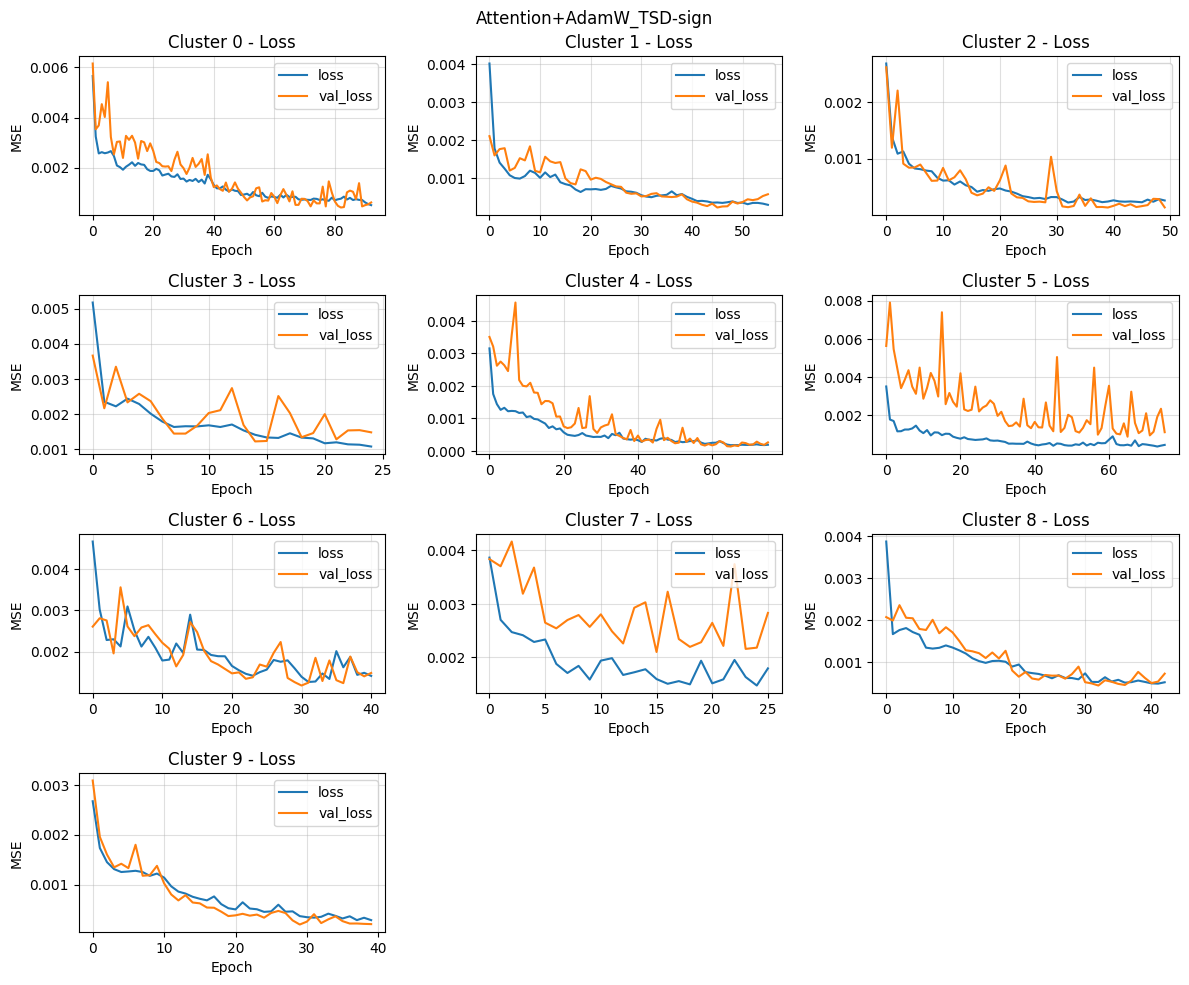

In [20]:
rows, cols = 5, 3
fig, axs = plt.subplots(rows, cols, figsize=(12, 12), squeeze=False)
plt.suptitle(model_arch_name)
for subpltn, dataset in enumerate(trainings):
    ax = axs[divmod(subpltn, cols)]
    ax.set_title(f"Cluster {dataset.cluster_n} - Loss")
    ax.plot(dataset.history.history["loss"])
    ax.plot(dataset.history.history["val_loss"])
    ax.set_ylabel("MSE")
    ax.set_xlabel("Epoch")
    ax.legend(["loss", "val_loss"], loc="upper right")
    ax.grid(alpha=0.4)
for subpltn in range(subpltn + 1, rows * cols):
    fig.delaxes(axs.flatten()[subpltn])  # removing empty plots from subplot grid
plt.tight_layout()
plt.show();

___

# 5. Feature Importance

In [21]:
feature_importances = []
for ith, dataset in tqdm(enumerate(trainings), total=len(trainings)):
    print(f"Evaluating feature importance on validation set of cluster {dataset.cluster_n}")

    x_valid = dataset.x_test[dataset.features]
    y_valid = dataset.y_test[: -model_params.sequence_length + 1].values.flatten()

    # Evaluate model baseline with all features
    oof_preds = dataset.model.predict(dataset.test_dataset, verbose=0).squeeze()
    baseline_mse = ((oof_preds - y_valid)**2).mean()
    results = {"cluster_n": dataset.cluster_n, "base_features": baseline_mse}

    # avoid shifting station/pollen encodings
    cluster_features = list(filter(lambda f: "id_" not in f, dataset.features))

    for feature in tqdm(cluster_features):
        x_valid_test = x_valid.copy()

        # shuffle feature k
        # x_valid_test[f] = np.random.shuffle(x_valid_test[f])
        x_valid_test[feature] = -100
        
        # x_valid_test = x_valid_test[feature].values

        # predict and evaluate mse
        x_valid_ds = tf.keras.preprocessing.timeseries_dataset_from_array(x_valid_test, targets=None, sequence_length=model_params.sequence_length, batch_size=model_params.batch_size)
        y_pred_shuffled = dataset.model.predict(x_valid_ds, verbose=0).squeeze() 
        feat_mse = ((y_valid - y_pred_shuffled)**2).mean()
        results[feature] = feat_mse
    
    feature_importances.append(results)

feature_importances = pd.DataFrame(feature_importances)
feature_importances

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating feature importance on validation set of cluster 0


  0%|          | 0/41 [00:00<?, ?it/s]

Evaluating feature importance on validation set of cluster 1


  0%|          | 0/41 [00:00<?, ?it/s]

Evaluating feature importance on validation set of cluster 2


  0%|          | 0/41 [00:00<?, ?it/s]

Evaluating feature importance on validation set of cluster 3


  0%|          | 0/41 [00:00<?, ?it/s]

Evaluating feature importance on validation set of cluster 4


  0%|          | 0/41 [00:00<?, ?it/s]

Evaluating feature importance on validation set of cluster 5


  0%|          | 0/41 [00:00<?, ?it/s]

Evaluating feature importance on validation set of cluster 6


  0%|          | 0/41 [00:00<?, ?it/s]

Evaluating feature importance on validation set of cluster 7


  0%|          | 0/41 [00:00<?, ?it/s]

Evaluating feature importance on validation set of cluster 8


  0%|          | 0/41 [00:00<?, ?it/s]

Evaluating feature importance on validation set of cluster 9


  0%|          | 0/41 [00:00<?, ?it/s]

,cluster_n,base_features,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_max_amax,B14198_mean_mean,B14198_min_amin,B14198_std_mean,...,pol_value_prev_6,pol_value_prev_7,pol_value_skew,pol_value_std,season_signature,station_H_mslm_amax,station_H_piano_strada_amax,station_lat_amax,station_lon_amax,trend_signature
0,0,0.000471,0.008506,0.007818,0.009505,0.009582,0.011926,0.010537,0.012376,0.014487,...,0.008104,0.006308,0.006110,0.009511,0.008071,0.008000,0.008078,0.008263,0.009896,0.014538
1,1,0.000293,0.002707,0.007392,0.003412,0.003642,0.003507,0.003017,0.003362,0.003391,...,0.013205,0.012976,0.002645,0.003209,0.002728,0.004501,0.006603,0.003256,0.005197,0.002818
2,2,0.000238,0.003892,0.003653,0.004139,0.004010,0.004147,0.003849,0.004233,0.003928,...,0.021029,0.053523,0.004927,0.003933,0.004440,0.004556,0.005094,0.003869,0.003872,0.003850
3,3,0.001457,0.005654,0.004779,0.005618,0.004678,0.004887,0.006378,0.006658,0.007340,...,0.006624,0.013249,0.009277,0.014571,0.013059,0.005114,0.010951,0.005810,0.007142,0.005073
4,4,0.000306,0.004634,0.005045,0.006034,0.004564,0.006212,0.004560,0.008019,0.007389,...,0.004654,0.009972,0.005098,0.004784,0.004700,0.004831,0.004858,0.004579,0.007725,0.004468
5,5,0.000504,0.003665,0.003588,0.004098,0.003365,0.005228,0.004008,0.007067,0.004666,...,0.031094,0.016872,0.004779,0.003701,0.003842,0.003823,0.003720,0.007085,0.003497,0.014524
6,6,0.001328,0.004378,0.017550,0.005077,0.023846,0.003441,0.003919,0.005948,0.004352,...,0.092639,0.052199,0.017383,0.016432,0.029079,0.008214,0.004118,0.006319,0.005423,0.004229
7,7,0.001789,0.004862,0.010223,0.004099,0.005099,0.005805,0.005153,0.004823,0.003956,...,0.071374,0.131102,0.006952,0.005603,0.007283,0.004821,0.031233,0.003776,0.003763,0.099711
8,8,0.000483,0.002682,0.002613,0.002778,0.002579,0.002597,0.002956,0.002603,0.002642,...,0.002667,0.068073,0.005701,0.002846,0.004568,0.003343,0.002694,0.002762,0.002655,0.003765
9,9,0.000281,0.004581,0.012904,0.003915,0.003831,0.005968,0.004411,0.039220,0.005528,...,0.004983,0.240123,0.004643,0.004680,0.019105,0.034103,0.005744,0.003488,0.066662,0.006653


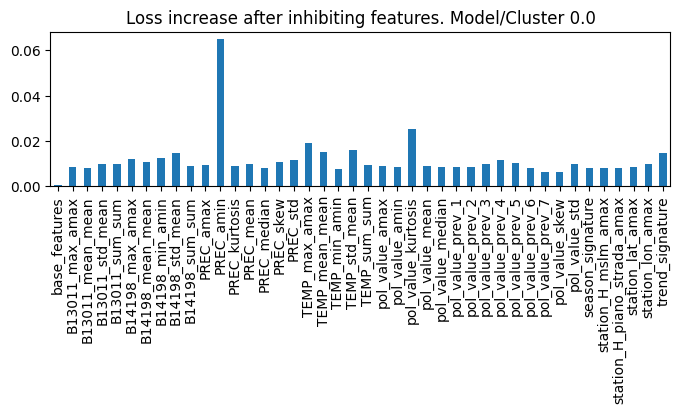

In [22]:
plt.figure(figsize=(8, 2))
plt.title(f"Loss increase after inhibiting features. Model/Cluster {feature_importances.iloc[0].cluster_n}")
feature_importances.drop("cluster_n", axis=1).iloc[0].plot.bar();

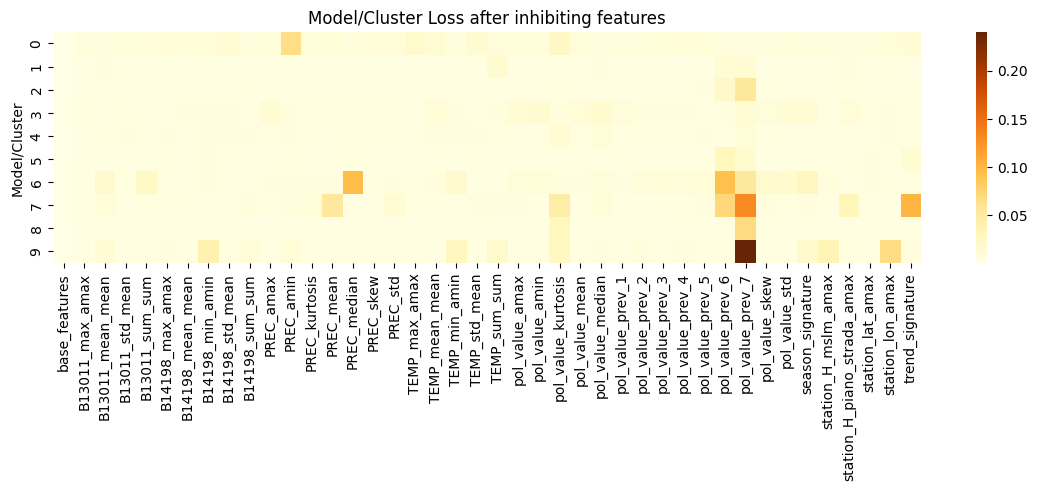

In [23]:
plt.figure(figsize=(14, 3))
plt.title("Model/Cluster Loss after inhibiting features")
sns.heatmap(data=feature_importances.drop("cluster_n", axis=1), cmap="YlOrBr");
plt.ylabel("Model/Cluster");

In [24]:
max_loss = feature_importances.drop(["cluster_n", "base_features"], axis=1)
max_loss = max_loss.apply(np.max).sort_values(ascending=False)
max_loss

pol_value_prev_7               0.240123
trend_signature                0.099711
PREC_median                    0.095423
pol_value_prev_6               0.092639
station_lon_amax               0.066662
PREC_amin                      0.064969
PREC_mean                      0.051998
pol_value_kurtosis             0.045772
B14198_min_amin                0.039220
station_H_mslm_amax            0.034103
station_H_piano_strada_amax    0.031233
TEMP_min_amin                  0.029709
season_signature               0.029079
B13011_sum_sum                 0.023846
TEMP_sum_sum                   0.019564
TEMP_max_amax                  0.019057
B13011_mean_mean               0.017550
pol_value_skew                 0.017383
pol_value_std                  0.016432
pol_value_median               0.016209
pol_value_amin                 0.016011
TEMP_std_mean                  0.015717
pol_value_amax                 0.015189
TEMP_mean_mean                 0.015166
B14198_std_mean                0.014487


In [25]:
mean_loss = feature_importances.drop(["cluster_n", "base_features"], axis=1)
mean_loss = mean_loss.apply(np.mean).sort_values(ascending=False)
mean_loss

pol_value_prev_7               0.060440
pol_value_prev_6               0.025637
pol_value_kurtosis             0.016980
trend_signature                0.015963
PREC_median                    0.013752
PREC_amin                      0.012136
station_lon_amax               0.011583
season_signature               0.009687
PREC_mean                      0.009556
B14198_min_amin                0.009431
TEMP_min_amin                  0.008820
station_H_piano_strada_amax    0.008309
station_H_mslm_amax            0.008131
TEMP_sum_sum                   0.007979
pol_value_median               0.007879
B13011_mean_mean               0.007556
pol_value_std                  0.006927
pol_value_skew                 0.006752
B13011_sum_sum                 0.006520
TEMP_mean_mean                 0.006321
pol_value_amin                 0.006248
pol_value_amax                 0.006232
pol_value_prev_5               0.006144
B14198_sum_sum                 0.006033
PREC_amax                      0.005938
